<a href="https://colab.research.google.com/github/lisaGUZZI/Soft-morph/blob/main/notebooks/example_soft_morph_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example SoftMorphOperator2D

In [11]:
! git clone https://github.com/lisaGUZZI/Soft-morph 
%cd Soft-morph

Cloning into 'Soft-morph'...


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from PIL import Image
from soft_morph import SoftSkeletonizer2D, SoftErosion2D, SoftDilation2D, SoftClosing2D, SoftOpening2D


ModuleNotFoundError: No module named 'soft_morph'

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Function to import the data and convert to tensor
def import_data(image_path):
    image_np = np.ceil(np.array(Image.open(image_path).convert("L"), dtype = np.int16)/255)
    image_ts = torch.tensor(image_np, device=DEVICE).unsqueeze(0).unsqueeze(0)
    return image_ts

# Function to generate the probabilistic image
def generate_probabilistic_image(binary_image, scaling_factor):
    # Move the tensor back to CPU for NumPy operations
    binary_image_cpu = binary_image.squeeze().cpu().numpy()

    # Perform CPU operations using NumPy
    distances_fg = distance_transform_edt(binary_image_cpu) * scaling_factor
    distances_bg = distance_transform_edt(1 - binary_image_cpu) * scaling_factor
    distance_map = distances_fg - distances_bg
    
    # Normalize the distance map
    min_val = np.min(distance_map)
    max_val = np.max(distance_map)
    probabilistic_image = (distance_map - min_val) / (max_val - min_val)
    
    # Convert back to Torch tensor and move to the appropriate device (CPU or CUDA)
    return (
        torch.tensor(probabilistic_image, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0),
        distance_map,
    )

# Function to plot the morphological operations
def makefigtable(listoutputs, row_titles, col_titles):
    nbrows, nbcols = len(listoutputs), len(listoutputs[0])
    # print(nbrows, nbcols)
    fig, axes = plt.subplots(nrows=nbrows, ncols=nbcols, figsize=(12, 5), sharex=True, sharey=True)

    for i in range(nbrows):
        # print(i)
        for j in range(nbcols):
            # print(j)
            listoutputs[i][j] = listoutputs[i][j].cpu().numpy()
            axes[i, j].imshow(listoutputs[i][j], cmap=plt.cm.gray)
            axes[i, j].axis('off')

            # Set row titles
            if j == 0:
                # axes[i, j].set_ylabel(row_titles[i], fontsize=16, rotation=-90, ha='left', va='center')
                axes[i, j].text(-0.2, 0.5, row_titles[i], fontsize=15, rotation=90, ha='center', va='center', transform=axes[i, j].transAxes)

            # Set column titles
            if i == 0:
                axes[i, j].set_title(col_titles[j], fontsize=16)

    fig.tight_layout()
    plt.show()

In [4]:

def simple_operation(image):
    # Define filters
    erode = SoftErosion2D(max_iter=1, connectivity=8)
    erode.to(DEVICE)
    dilate = SoftDilation2D(max_iter=2, connectivity=4)
    dilate.to(DEVICE)
    skeleton = SoftSkeletonizer2D(max_iter=5)
    skeleton.to(DEVICE)
    close = SoftClosing2D(max_iter=2, dilation_connectivity=8, erosion_connectivity=8)
    close.to(DEVICE)
    openn = SoftOpening2D(max_iter=2, dilation_connectivity=4, erosion_connectivity=4)
    openn.to(DEVICE)

    eroded = erode(image)
    dilated = dilate(image)
    skeletonized = skeleton(image)
    closed = close(image)
    opened = openn(image)
    return [image.squeeze(), eroded.squeeze(), dilated.squeeze(), skeletonized.squeeze(), closed.squeeze(), opened.squeeze()]

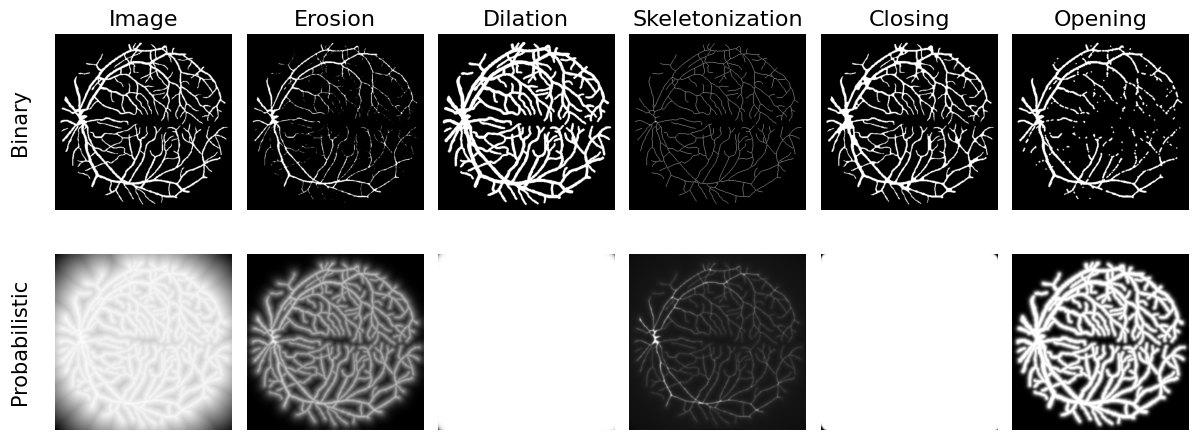

In [5]:
binary_image = import_data("data/example_data.png") # Import binary image
probabilistic_image, dist_map = generate_probabilistic_image(binary_image, 0.05) # Create image with continuous values between 0 and 1

# simple operation
binary_results = simple_operation(binary_image)
proba_results = simple_operation(probabilistic_image)
col = ["Image", "Erosion", "Dilation", "Skeletonization", "Closing", "Opening"]
row = ["Binary", "Probabilistic"]
makefigtable([binary_results, proba_results],row, col)